## Ideas

### Features
- Sex: 
    - encode as is_male
- Age: 
    - a lot of missing values, they are not of the same population - so keep a has_age flag
    - add is_child and is_infant flags, and perhaps others
    - Age is a real property, so we will fill it with MICE and not (-1) or some other fixed value
- Embarked:
    - one-hot-oncode
    - has a few missing values, use MICE
- Pclass:
    - as-is
- Cabin: 
    - breakdown cabin to Deck / room features
    - add location of room on deck feature (Front/Back, distance to exit, doors etc)
    - NaN Cabin is a feature - I guess not everyone had a cabin: seems to have a huge impact on Survival and Fare price
    - For groups that traveled together (by ticket), they often but NOT always have the same Cabin, sometimes some have a cabin while others don't
    - For some people, Cabin looks like multiple rooms
- Fare:
    - add log(Fare) feature
    - People with Fare=0, are they special passengers (Crew?) or is it just random missing data? We can try both adding a zero_Fare flag and imputing with MICE
- Name:    
    - Extract "Title" info from names as features:
        - should we group all uncommon titles together?
        - Is the title info for top titles embedded in Sex/is_adult information?
        - we could fill some missing Age informaion from Title? Best to do with MICE after extracting the Title feature (and others?)
    - Group by family name 
    - Extract "class" from family name? does family name impact on chance of survival? does first name?
- Tickets: 
    - there are less unique tickets than passengers, perhaps families has the same ticket. The tickets are also spread accross train/test sets. If in fact having the same ticket means you are in the same "family group" then it might be a predictor for the people in test set that share a ticket with train set.
    - There are difference ticker prefixes, we should try extracting them as features
- Parch and SibSp: 
    - they each have a double meaning, perhaps we can seperate the meanings based on other features like Age?
    
### Notes
- people two traveled together, had the same Cabin-set (multiple cabins in the Cabin field. FALSE), had the same ticket number, had their Fare summed together. They also likely Embarked in the same place and had the same Family name
    
### cross-validation during model training
- data is not iid
- when we split, we should try and keep the distribution of the data the same
- look at the distributions of each feature between df_train and df_test! if there are significant differences, we should try to adjust our data to match that of df_test

In [393]:
%load_ext autoreload
%autoreload 2

#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x)) #Limiting floats output to
pd.options.display.max_rows = 999

color = sns.color_palette()
sns.set_style('darkgrid')
from scipy.stats import norm, skew #for some statistics

import sys
sys.path.insert(0, "/Users/user/git/datasci")
from sci.metrics import rmse_score
from plots import *
import sci.features as scif
from sci.plots import *
import sci.learn as scil


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [395]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')

df_train = df_train.set_index("PassengerId")
df_test = df_test.set_index("PassengerId")

df_all = pd.concat([df_train, df_test])
df_all.loc[df_train.index, "set"] = "train"
df_all.loc[df_test.index, "set"] = "test"

print(df_train.shape)
print(df_test.shape)

df = df_train

(891, 11)
(418, 10)


In [415]:
scif.df_summary(df_train)

,count,missing,percent,dtype,types,uniq,values,freq
Cabin,204,687,77.1044,object,str,147,"A10, A14, A16, A19, A20, A23, A24, A26, ...","'G6':4, 'C23 C25 C27':4, 'B96 B98':4, 'F33..."
Age,714,177,19.8653,float64,float,88,"0.42, 0.67, 0.75, 0.83, 0.92, 1.0, 2.0, ...","'24.0':30, '22.0':27, '18.0':26, '19.0':25..."
Embarked,889,2,0.2245,object,str,3,"C, Q, S","'S':644, 'C':168, 'Q':77..."
Survived,891,0,0.0000,int64,int,2,"0, 1","'0':549, '1':342..."
Pclass,891,0,0.0000,int64,int,3,"1, 2, 3","'3':491, '1':216, '2':184..."
Name,891,0,0.0000,object,str,891,"Abbing, Mr. Anthony, ...","'Panula, Master. Juha Niilo':1, 'Hocking..."
Sex,891,0,0.0000,object,str,2,"female, male","'male':577, 'female':314..."
SibSp,891,0,0.0000,int64,int,7,"0, 1, 2, 3, 4, 5, 8","'0':608, '1':209, '2':28, '4':18, '3':16, '8..."
Parch,891,0,0.0000,int64,int,7,"0, 1, 2, 3, 4, 5, 6","'0':678, '1':118, '2':80, '5':5, '3':5, '4':..."
Ticket,891,0,0.0000,object,str,681,"110152, 110413, 110465, 110564, 110813, ...","'1601':7, '347082':7, 'CA. 2343':7, '31012..."


In [389]:
scif.df_comp(df_train.drop(["Survived", "Name", "Ticket", "Cabin"], axis=1), df_test.drop(["Name", "Ticket", "Cabin"], axis=1), "df_train", "df_test")



has NaN mismatch df_train vs df_test:
Embarked: df_train has NaN values, but df_test does not

has NaN mismatch df_test vs df_train:
Fare: df_test has NaN values, but df_train does not

dtype mismatch:

unique categorical values mismatch in df_train:

unique categorical values mismatch in df_test:


## Split Data

In [417]:

y = df_train["Survived"]
X = df_train.drop('Survived', axis=1)

print(df_train.shape)
print(df_test.shape)
print(X.shape)
print(y.shape)

(891, 11)
(418, 10)
(891, 10)
(891,)


## The Target

In [418]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y)

'binary'

In [419]:
y.mean()

0.3838383838383838

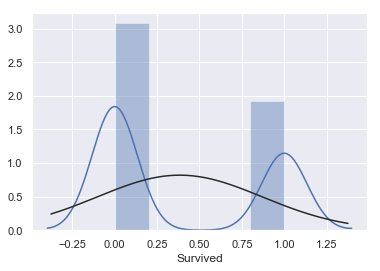

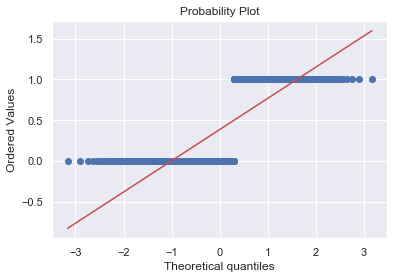

In [420]:
scip.normality(y)

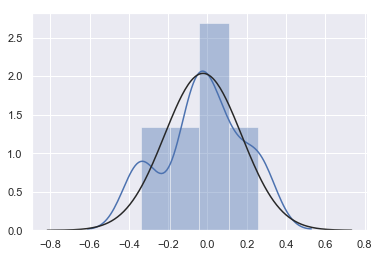

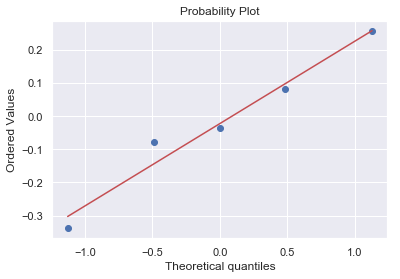

In [421]:
# the correlations are normally distributed! So we assume that the target variable is based on coeeficients which have been selected from N()
# it also seems that it's not perfectly normal.
# Atleast two coef' seem to be correlated much higher than normal
cors = X.corrwith(y)
scip.normality(cors)

## All Features

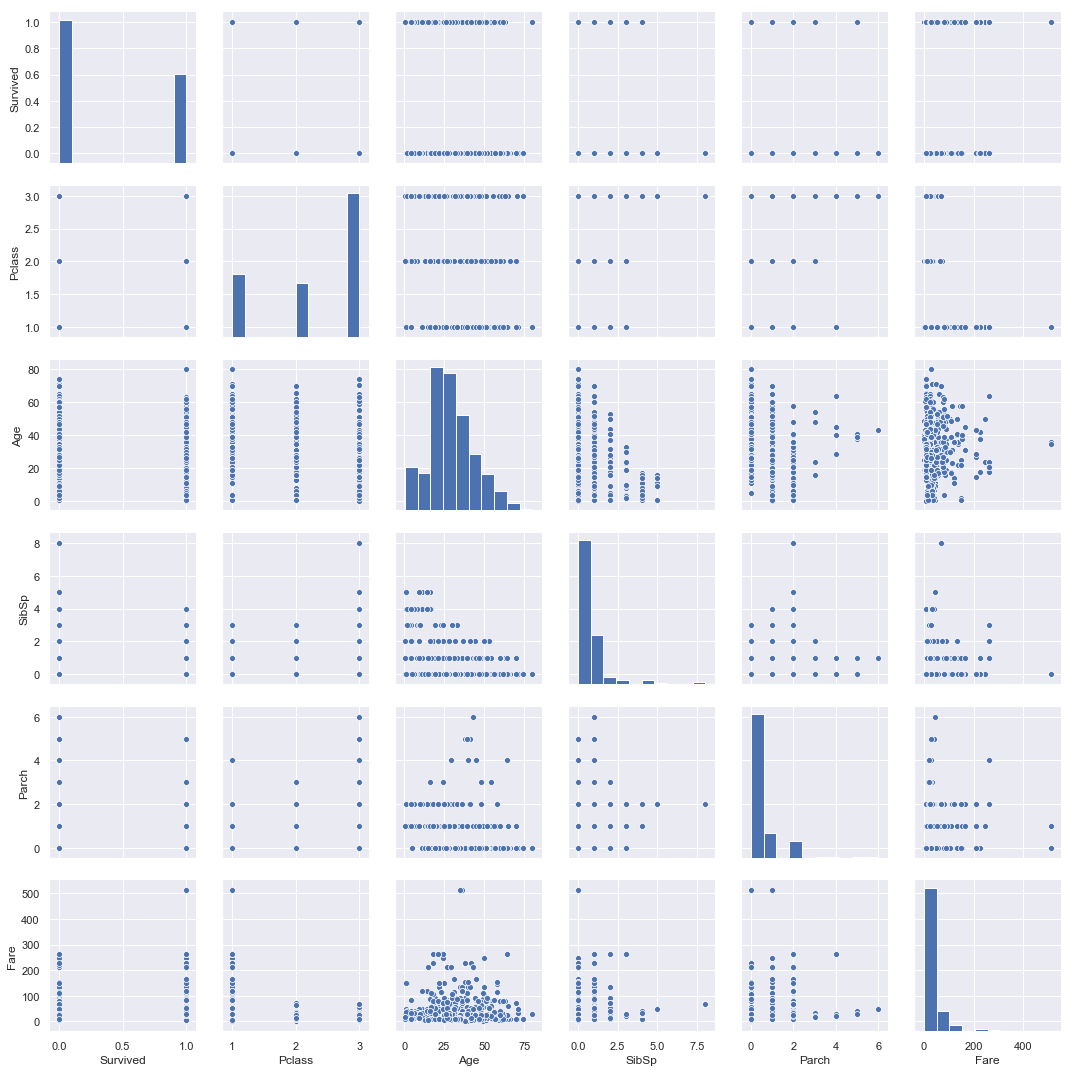

In [422]:
sns.pairplot(df_train)

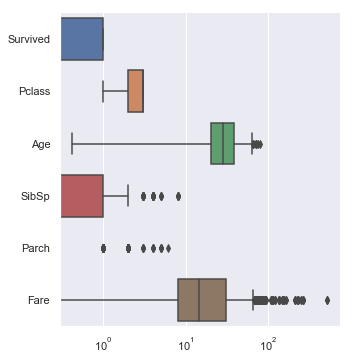

In [423]:
g = sns.catplot(data=df_train, orient="h", kind="box");
g.set(xscale="log");

## Age

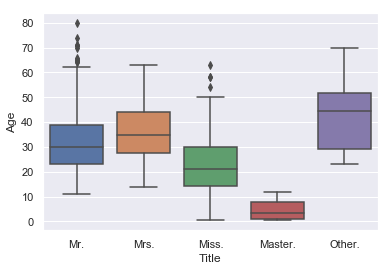

In [424]:
# Title isn't a very reliable "child" indicator
df = df_train.copy()
df["Title"] = df.Name.apply(lambda x: x.split(", ")[1].split(" ")[0])
df.loc[~df["Title"].isin(['Mr.', 'Miss.', 'Mrs.', 'Master.']), "Title"] = "Other."
sns.boxplot("Title", "Age",data=df)


In [430]:
df[(df.Title=="Miss.") & (df.Age > 18)]
df[(df.Title=="Mr.") & (df.Age < 18)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,has_age
PassengerId,,,,,,,,,,,,,
87,0,3,"Ford, Mr. William Neal",male,16.0000,1,3,W./C. 6608,34.3750,NaN,S,Mr.,True
139,0,3,"Osen, Mr. Olaf Elon",male,16.0000,0,0,7534,9.2167,NaN,S,Mr.,True
164,0,3,"Calic, Mr. Jovo",male,17.0000,0,0,315093,8.6625,NaN,S,Mr.,True
221,1,3,"Sunderland, Mr. Victor Francis",male,16.0000,0,0,SOTON/OQ 392089,8.0500,NaN,S,Mr.,True
267,0,3,"Panula, Mr. Ernesti Arvid",male,16.0000,4,1,3101295,39.6875,NaN,S,Mr.,True
283,0,3,"de Pelsmaeker, Mr. Alfons",male,16.0000,0,0,345778,9.5000,NaN,S,Mr.,True
334,0,3,"Vander Planke, Mr. Leo Edmondus",male,16.0000,2,0,345764,18.0000,NaN,S,Mr.,True
353,0,3,"Elias, Mr. Tannous",male,15.0000,1,1,2695,7.2292,NaN,C,Mr.,True
434,0,3,"Kallio, Mr. Nikolai Erland",male,17.0000,0,0,STON/O 2. 3101274,7.1250,NaN,S,Mr.,True


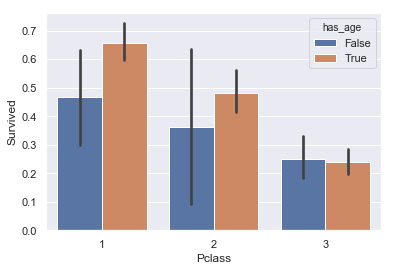

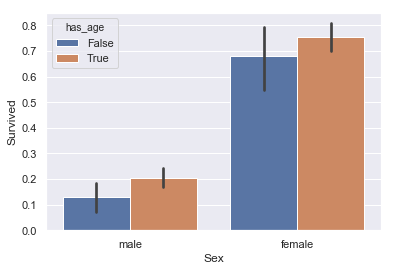

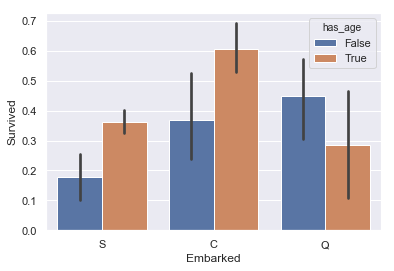

In [425]:
df["has_age"] = ~df.Age.isnull()

sns.barplot("Pclass", "Survived", hue="has_age", data=df)
plt.figure()
sns.barplot("Sex", "Survived", hue="has_age", data=df)
plt.figure()
sns.barplot("Embarked", "Survived", hue="has_age", data=df)

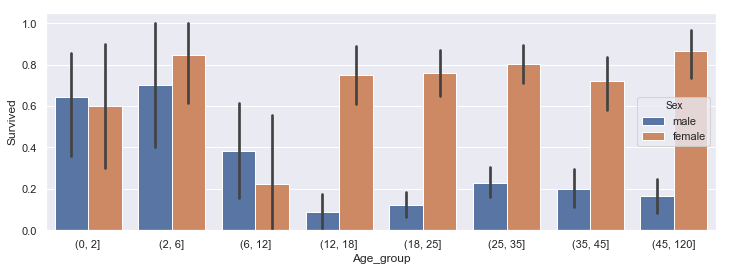

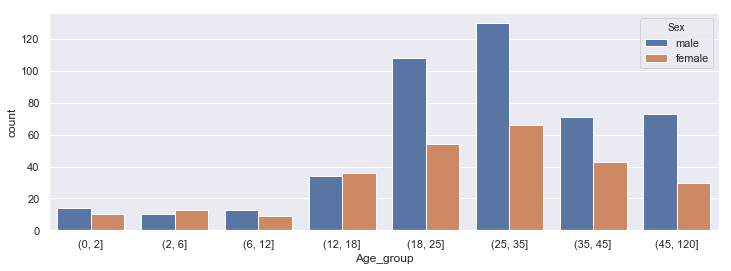

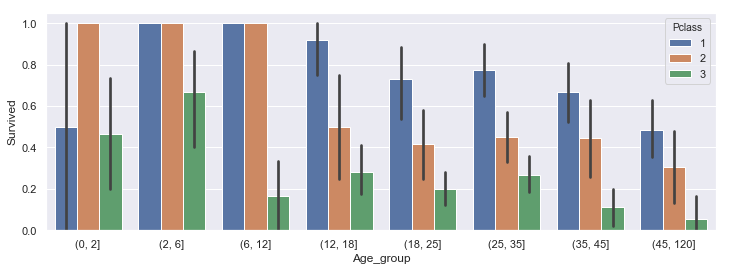

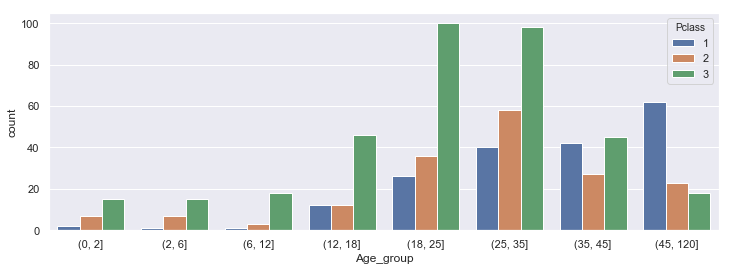

In [383]:
df["Age_group"] = pd.cut(df["Age"], [0, 2, 6, 12, 18, 25, 35, 45, 120])
# df["age_bucket"] = ((df["Age"] // 2) * 2).fillna(-1).astype(int)
df["has_age"] = ~df.Age.isnull()

plt.figure(figsize=(12, 4))
sns.barplot("Age_group", "Survived", hue="Sex", data=df, )
plt.figure(figsize=(12, 4))
sns.countplot("Age_group",  hue="Sex", data=df)

plt.figure(figsize=(12, 4))
sns.barplot("Age_group", "Survived", hue="Pclass", data=df, )
plt.figure(figsize=(12, 4))
sns.countplot("Age_group",  hue="Pclass", data=df)


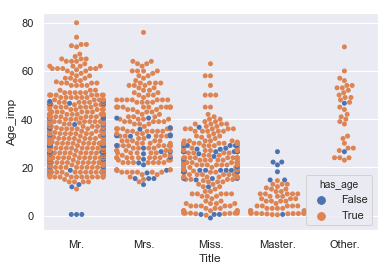

In [448]:
# imputing age
# imputing age works pretty well in keeping the imputed age within the expected "Title" agroups
# except: Master, which should not be above 18, and a few Mr. which get near zero

df = df_all.copy()

df["FamilyName"] = df.Name.apply(lambda x: x.split(", ")[0])
df["Title"] = df.Name.apply(lambda x: x.split(", ")[1].split(" ")[0])
df.loc[~df["Title"].isin(['Mr.', 'Miss.', 'Mrs.', 'Master.']), "Title"] = "Other."
df.drop("Name", axis=1, inplace=True)

df["Age_imp"] = scif.impute_iterative(df)["Age"]
df["has_age"] = df.Age.notnull()

sns.swarmplot("Title", "Age_imp", hue="has_age", data=df)

<Figure size 864x864 with 0 Axes>

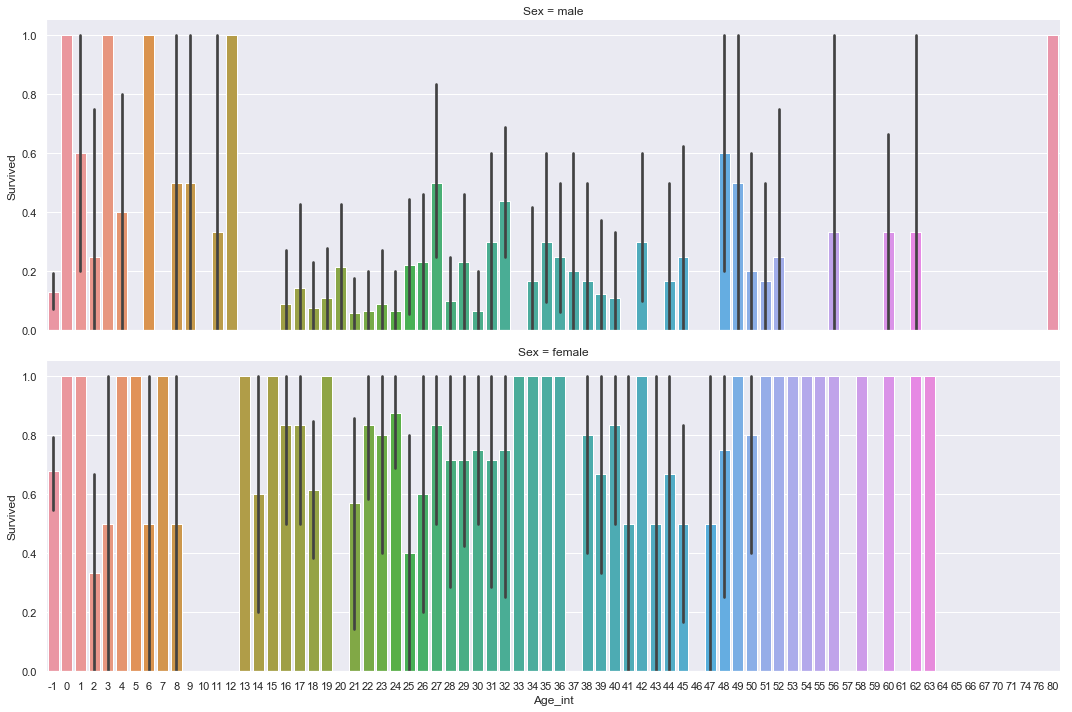

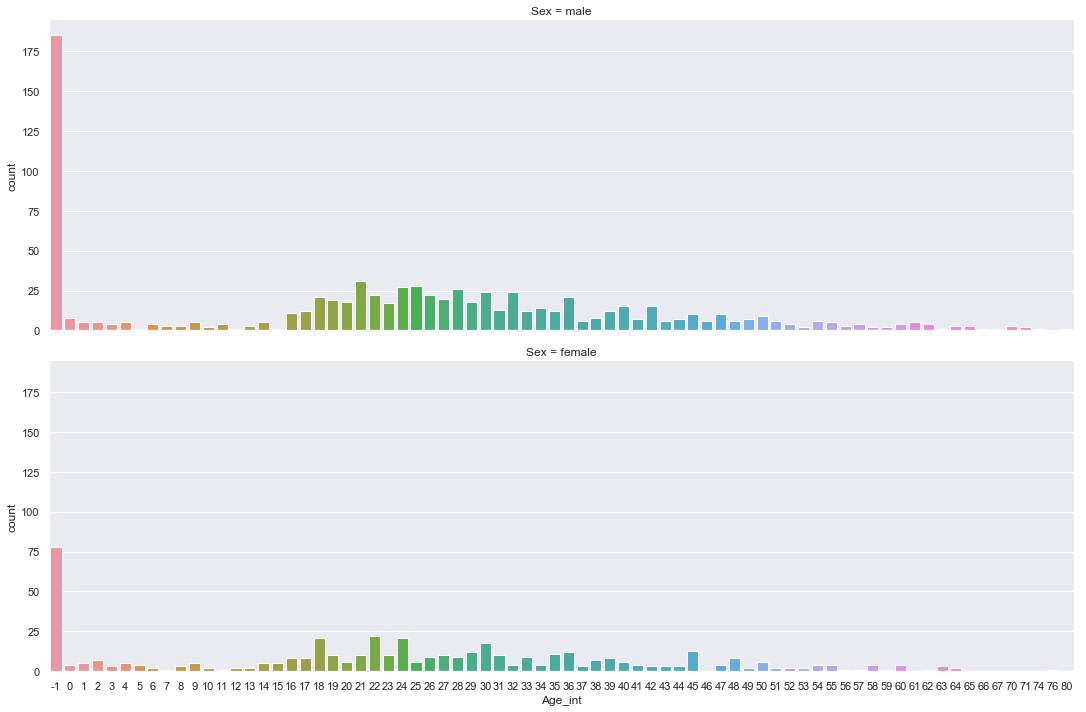

In [449]:
# who is a "child" ?
# is seems that men aged 16+ dies just as frequently as 20+, so they were probably treated as adults
# Master. titles end with 13 (and a single 14.5 outlier)
# Mr. title start with 14 (and a single 11 outlier)
# this indicates that the child cutoff for child is age < 14
# looking again at survival, there are NO male survivors ages 13-15 (though we do have some present that that group age)
# this might indicate (though this is guessing) that they were treated like adults
# ther are also oddly no female survivots ages 9-12
# so a "child" is Age < 16 (and not the "legal" 18)

df['Age_int'] = (df.Age // 1).fillna(-1).astype(int)

plt.figure(figsize=(12, 12))
sns.catplot("Age_int", "Survived", row="Sex", data=df, kind="bar", aspect=3)
sns.catplot("Age_int", row="Sex", data=df, kind="count", aspect=3)

# df[df.Sex=="male"].groupby("Age_int").Survived.sum()

## Groups

In [396]:
df = df.merge(df.groupby("Ticket").size().rename("group_size"), left_on="Ticket", right_index=True, how="outer", suffixes=('', ''))
df = df.merge(df.groupby("Cabin").size().rename("group_size2"), left_on="Cabin", right_index=True, how="outer", suffixes=('', ''))
df["group_size2"] = df["group_size2"].fillna(0)

In [397]:
df.pivot_table(index="group_size", columns="group_size2", aggfunc="size", fill_value=0, dropna=False)

group_size2,0.0,1.0,2.0,3.0,4.0
group_size,,,,,
1,458,67,13,9,0
2,117,19,48,0,4
3,35,12,13,3,0
4,28,3,2,3,8
5,10,0,0,0,0
6,18,0,0,0,0
7,21,0,0,0,0


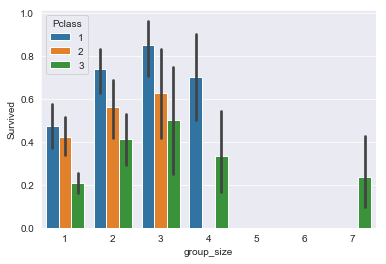

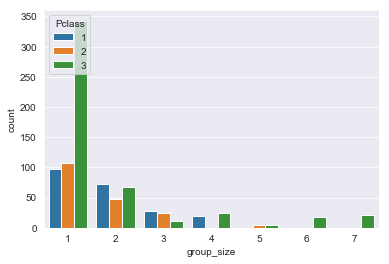

In [306]:
sns.barplot("group_size", "Survived", hue="Pclass", data=df)
# sns.barplot("group_size", "Survived", data=df)
plt.figure()
# sns.countplot(df["group_size"] )
sns.countplot("group_size", hue="Pclass", data=df)


## Fare

In [412]:
# Fare == 0 looks like a mistake in the data
df.loc[df.query("Fare == 0").index] = np.nan
# we add has_fare and them fill with MICE
df["has_fare"] = df["Fare"].notnull()

In [403]:
df["fare_norm"] = df["Fare"] / df["group_size"]

In [406]:
df["fare_q"] = pd.qcut(df["fare_norm"], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

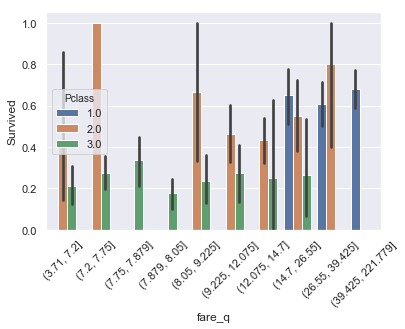

In [411]:
g = sns.barplot("fare_q", "Survived", hue="Pclass", data=df)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

## Single Feature vs Target

In [317]:
f = "has_cabin"

target = "Survived"
alt_target = "Fare"

by = "has_cabin"
multi = "Embarked"

# v = df_train[f].fillna('missing')
df = df_train

### Categorical scatterplots:

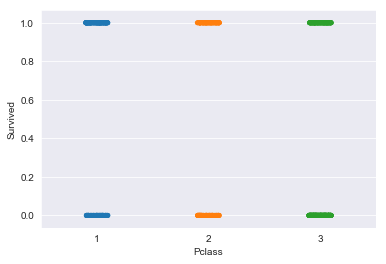

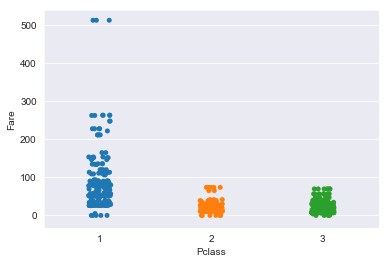

In [202]:
# box plot
sns.stripplot(f, target, data=df)
plt.figure()
sns.stripplot(f, alt_target, data=df)

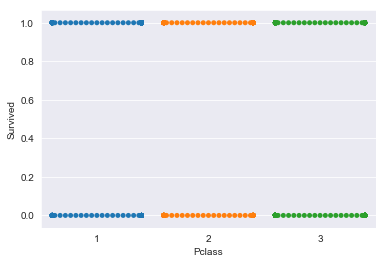

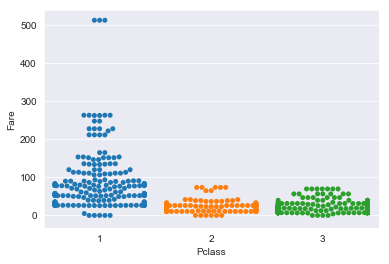

In [15]:
sns.swarmplot(f, target, data=df)
plt.figure()
sns.swarmplot(f, alt_target, data=df)

### Categorical distribution plots:

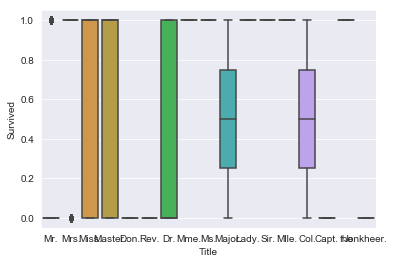

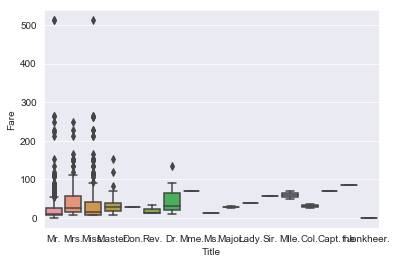

In [187]:
# box plot
sns.boxplot(f, target, data=df)
plt.figure()
sns.boxplot(f, alt_target, data=df)
# plt.yscale('log')

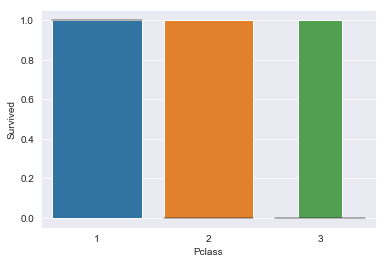

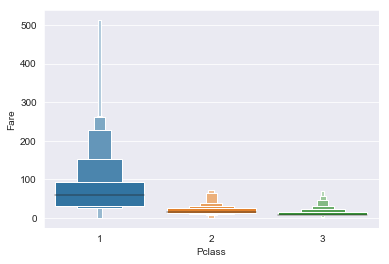

In [17]:
# boxen plot
sns.boxenplot(f, target, data=df)
plt.figure()
sns.boxenplot(f, alt_target, data=df)

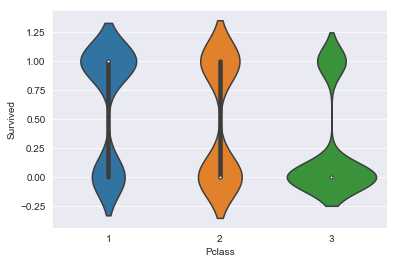

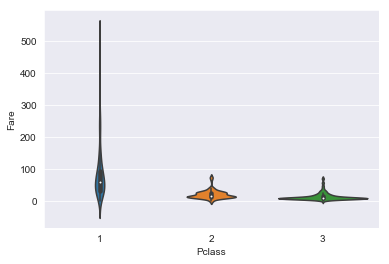

In [18]:
# violin plot
sns.violinplot(f, target, data=df)
plt.figure()
sns.violinplot(f, alt_target, data=df)

### Categorical estimate plots:

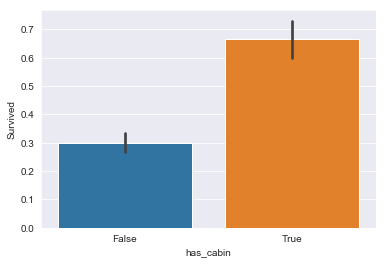

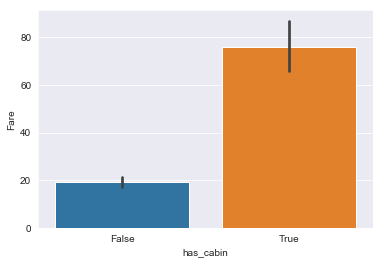

In [206]:
# bar plot
sns.barplot(f, target, data=df)
plt.figure()
sns.barplot(f, alt_target, data=df)

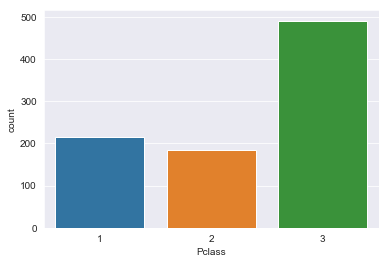

In [20]:
# count plot
sns.countplot(f, data=df)

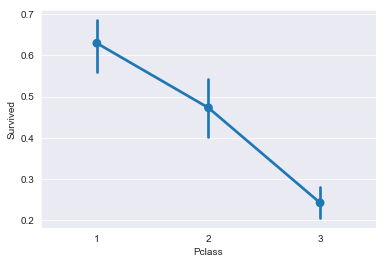

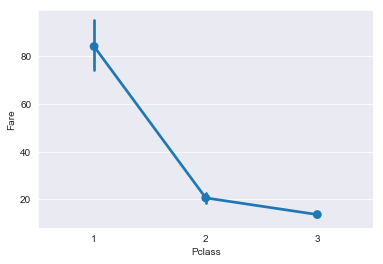

In [21]:
# point plot
sns.pointplot(f, target, data=df)
plt.figure()
sns.pointplot(f, alt_target, data=df)

## Multi dimensional

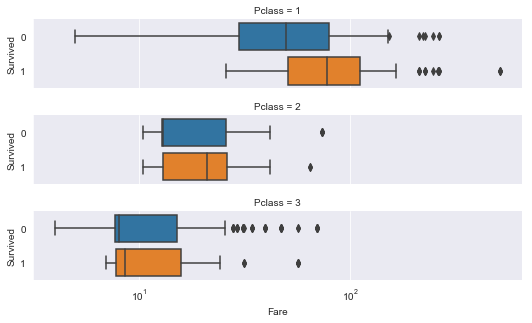

In [24]:
g = sns.catplot(x="Fare", y="Survived", row="Pclass",
                kind="box", orient="h", height=1.5, aspect=5,
                data=df.query("Fare > 0"))
g.set(xscale="log");

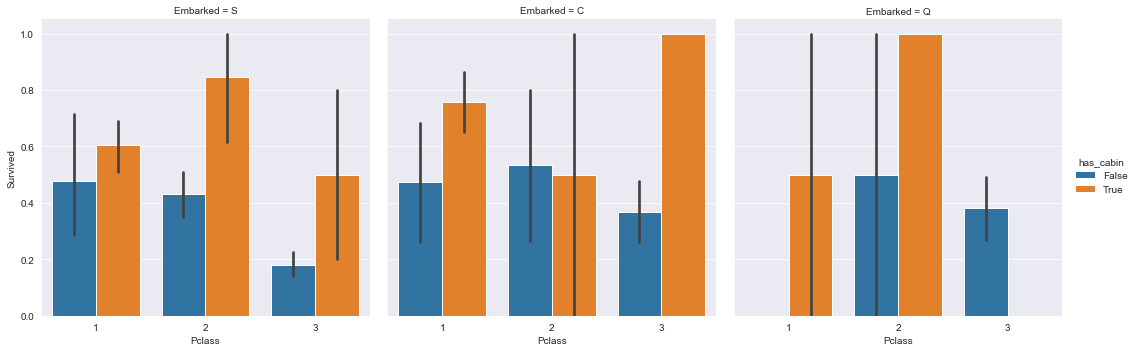

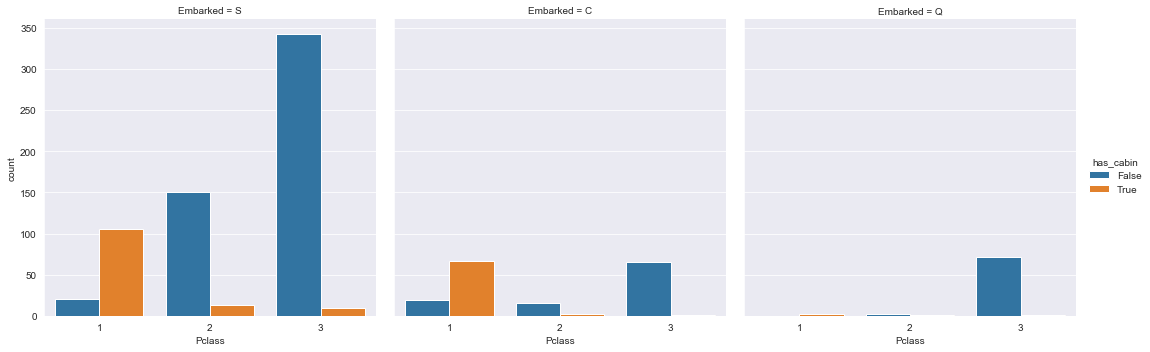

In [204]:
# breakdown on 2 extra features: hue= and col=
sns.catplot(x=f, y=target, hue=by, kind="bar", data=df, col=multi);
# also add a count plot below
sns.catplot(x=f, hue=by, kind="count", data=df, col=multi);

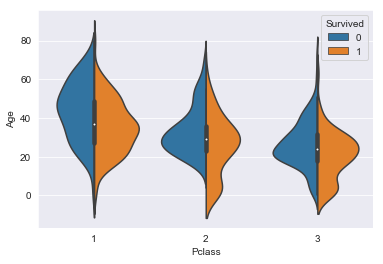

In [23]:
sns.violinplot("Pclass", "Age", hue="Survived", split=True, data=df)

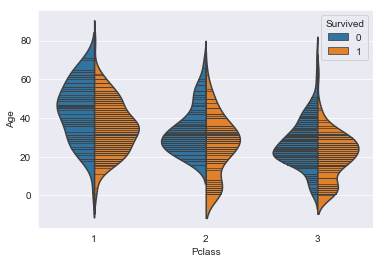

In [39]:
# show the interior of the violin plot
sns.violinplot("Pclass", "Age", hue="Survived", split=True, inner="stick", data=df);

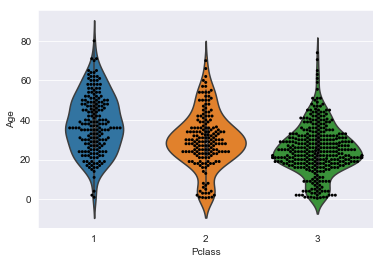

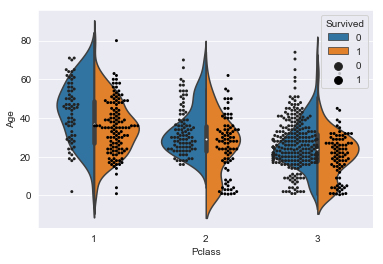

In [35]:
# show the interior of the violin plot
g = sns.violinplot("Pclass", "Age", data=df)
sns.swarmplot("Pclass", "Age", color="k", size=3, data=df, ax=g);

plt.figure()
g = sns.violinplot("Pclass", "Age", hue="Survived", split=True, data=df)
sns.swarmplot("Pclass", "Age", hue="Survived", color="k", split=True, size=3, data=df, ax=g);

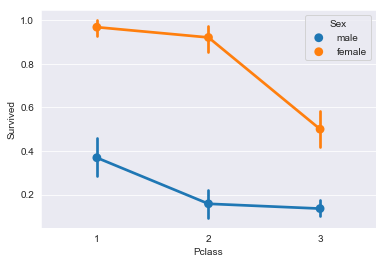

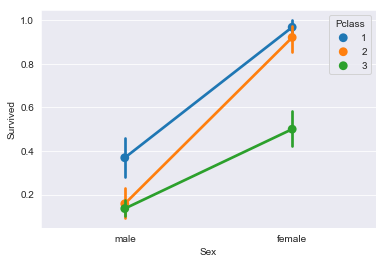

In [26]:
# sns.catplot(x=f, hue=by, y=target, kind="point", data=df);
sns.pointplot(x=f, hue=by, y=target, data=df)
plt.figure()
sns.pointplot(x=by, hue=f, y=target, data=df)

## Compare train/test sets

Mean: 29.699118
Std: 14.516321
Skewness: 0.388290
Kurtosis: 0.168637
Mean: 30.272590
Std: 14.159836
Skewness: 0.455292
Kurtosis: 0.064509


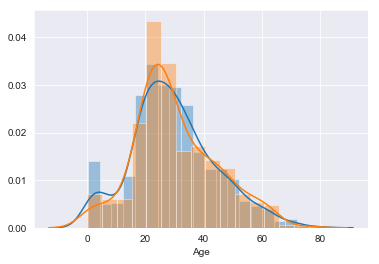

In [102]:
scip.dist(df_train["Age"].dropna())
scip.dist(df_test["Age"].dropna())

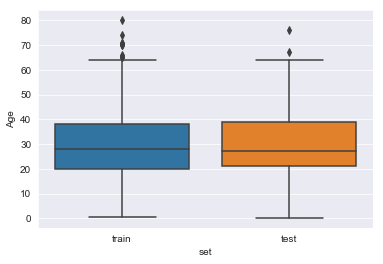

In [107]:
sns.boxplot("set", "Age", data=df_all)

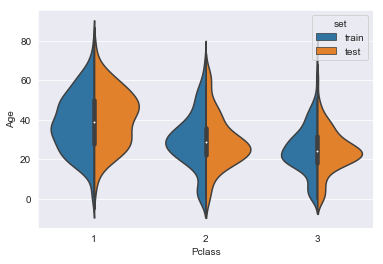

In [110]:
sns.violinplot("Pclass", "Age", hue="set", split=True, data=df_all)
# sns.violinplot("Sex", "Age", hue="set", split=True, data=df_all)

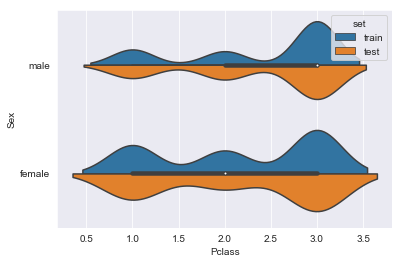

In [152]:
sns.violinplot("Pclass", "Sex", hue="set", split=True, data=df_all)
# sns.violinplot("Sex", "Age", hue="set", split=True, data=df_all)

In [149]:
# compare frequency ratios
f = "Pclass"
a = df_test[f].value_counts() / len(df_test)
b = df_train[f].value_counts() / len(df_train)
xx = pd.DataFrame({"test": a, "train": b, f: a.index})
xx
# TODO: how to visualize?

,test,train,Pclass
3,0.5215,0.5511,3
1,0.2560,0.2424,1
2,0.2225,0.2065,2


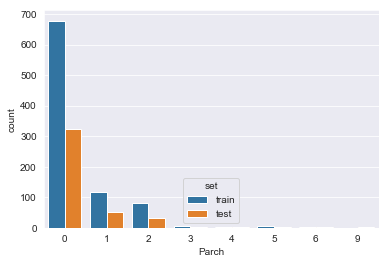

In [118]:
sns.countplot("Parch", hue="set", data=df_all)

## PCA features

In [176]:
# from the shape of the PCA explain variance we deduce that feature selection has little use, as most features are usefull, and their impact is smoothly deminishing (syntethic dataset)
scip.pca_component_variance(df_train)

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

## Correlation Matrix

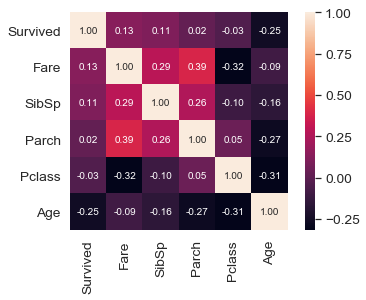

In [181]:
scip.corr_matrix_top(df_train.dropna(), "Survived")

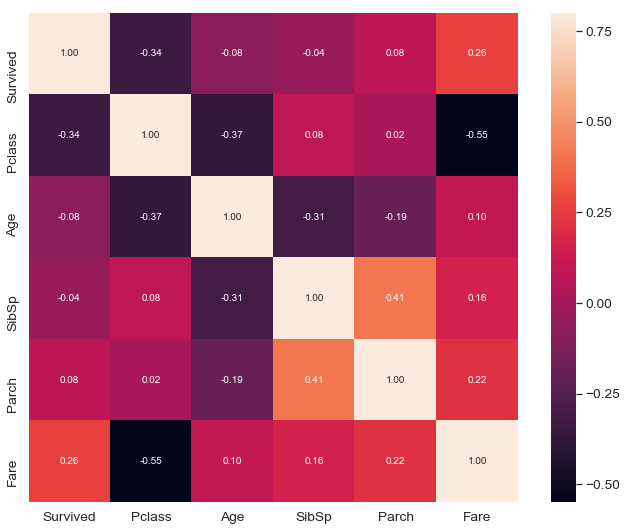

In [186]:
scip.corr_matrix(df_train, annot=True)

## Normality

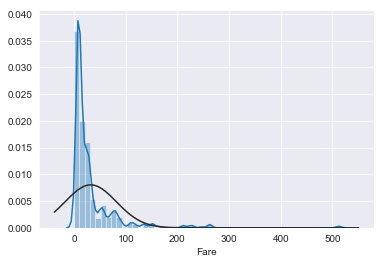

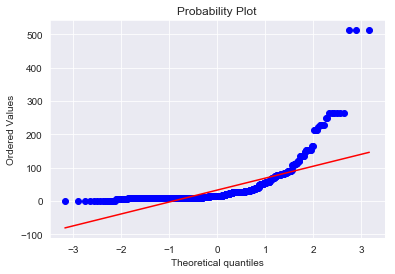

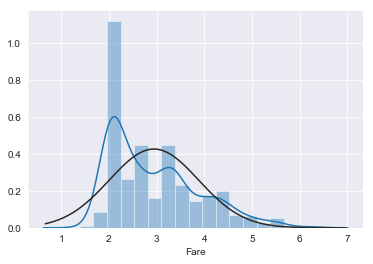

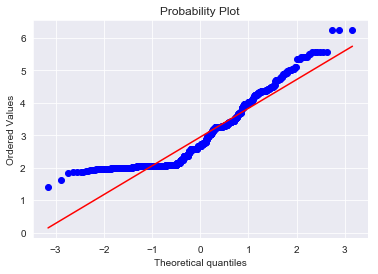

In [61]:
scip.normality(X['Fare'].dropna())
scip.normality(np.log(X['Fare'][X['Fare']>0]))

### Normalize

Skewness: 0.000158
Kurtosis: 0.670501


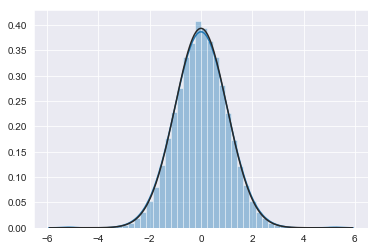

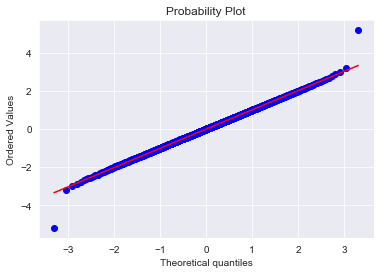

In [82]:
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html#sphx-glr-auto-examples-preprocessing-plot-map-data-to-normal-py

from sklearn.preprocessing import PowerTransformer, QuantileTransformer

tr = PowerTransformer('yeo-johnson')
tr = PowerTransformer('box-cox')
tr = QuantileTransformer(output_distribution='normal', n_quantiles=10000)

z = tr.fit_transform(y.to_frame())
z = z[:, 0]

# tr = PowerTransformer('yeo-johnson')
# z = tr.fit_transform(y.to_frame())
# z = z[:, 0]

# z = tr.inverse_transform(z.reshape(-1, 1))
# z = z[:, 0]

# z = np.log(y)
plot_normality(z)

skew: 0.12121036730137079
lam: 0.7889241706670747
skew: 0.06252532668488879
Skewness: 0.062525
Kurtosis: 0.833391


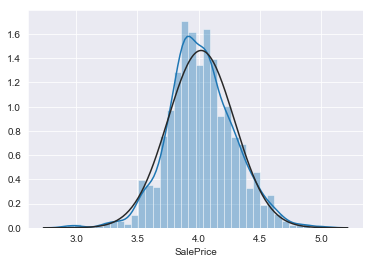

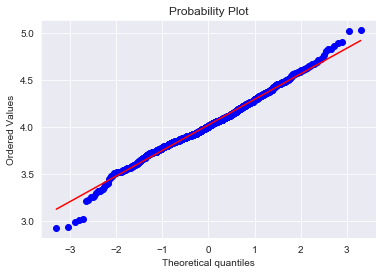

In [63]:
# plot_normality(np.power(y, 1/200000)) # postiive skew is often reduced with log transform
z = np.log(y)
# z = z - z.mean()
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

print('skew:', skew(z))
lam = 0.15
lam = boxcox_normmax(z)
print('lam:', lam)
z = boxcox1p(z, lam)
print('skew:', skew(z))

plot_normality(z.dropna())


## homoscedasticity

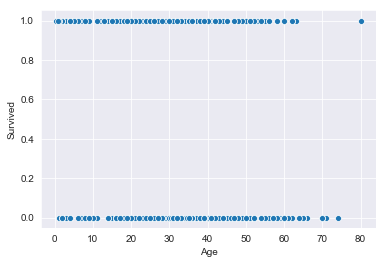

In [46]:
# log transformation help with homoscedasticity
scip.scatter(X['Age'], y)
# plot_scatter(np.log(X['GrLivArea']), np.log(y))

## crosstab related features

In [92]:
df = df_train
display(pd.crosstab(df['SaleCondition'], df['SaleType']))

SaleType,COD,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD
SaleCondition,,,,,,,,,
Abnorml,24,1,0,2,1,0,0,3,70
AdjLand,0,0,0,0,0,0,0,0,4
Alloca,0,0,0,0,0,0,0,0,12
Family,0,1,0,0,0,0,0,0,19
Normal,19,2,2,6,4,5,0,0,1160
Partial,0,0,0,1,0,0,122,0,2


## Missings in subsets of features

In [84]:
df = df_train
cols = [x for x in df.columns if 'Garage' in x]
df = df[cols]
scif.df_summary(df, missing_only=False)

,count,missing,percent,dtype,uniq,values,freq
GarageType,1379,81,5.5479,object,6,"2Types, Attchd, Basment, BuiltIn, ...","'Attchd':870, 'Detchd':387, 'BuiltIn':88, ..."
GarageYrBlt,1379,81,5.5479,float64,97,"1900.0, 1906.0, 1908.0, 1910.0, 1914.0, ...","'2005.0':65, '2006.0':59, '2004.0':53, '20..."
GarageFinish,1379,81,5.5479,object,3,"Fin, RFn, Unf","'Unf':605, 'RFn':422, 'Fin':352..."
GarageQual,1379,81,5.5479,object,5,"Ex, Fa, Gd, Po, TA","'TA':1311, 'Fa':48, 'Gd':14, 'Ex':3, 'Po':3..."
GarageCond,1379,81,5.5479,object,5,"Ex, Fa, Gd, Po, TA","'TA':1326, 'Fa':35, 'Gd':9, 'Po':7, 'Ex':2..."
GarageCars,1460,0,0.0000,int64,5,"0, 1, 2, 3, 4","'2':824, '1':369, '3':181, '0':81, '4':5..."
GarageArea,1460,0,0.0000,int64,441,"0, 160, 164, 180, 186, 189, 192, 198, ...","'0':81, '440':49, '576':47, '240':38, '484'..."


## Base multi-variate 'mode', and unusual samples from 'mode'

In [ ]:
base_mode = show_most_common_multi_col_mode(df_train, col_contains="Bsmt")
display(base_mode[["mode"]].T)
unusual = show_unusual_rows_from_base_mode(df_train, col_contains="Bsmt")
display(unusual['_unusual'].value_counts())
unusual.query('_unusual == 1')

## Groups

In [ ]:
df_train.query('Cabin == "C23 C25 C27"')